# COVID-19-detection-ML-DL
Детектирование наличия COVID-19 либо вирусной пневмонии на рентгеновских снимках легких с помощью алгоритмов машинного и глубокого обучения.

## Оглавление
1) Загрузка необходимых библиотек и инструментов.
- os
- cv2
- scikit-image
- numpy
2) Создание отдельных функций:
- загрузки изображений
- выделения LBP-признаков
- разметки примеров.
3) Загрузка и предобработка датасета

In [43]:
# Загрузка необходимых библиотек и инструментов
import os # Библиотека для работы с функциями ОС
import cv2 # Библиотека для работы с изображениями
from skimage.feature import local_binary_pattern # Инструмент извлечения LBP-признаков
import numpy as np # Библиотека для математических операций
import matplotlib.pyplot as plt # Библиотека для визуализации данных
import seaborn as sns # Библиотека для визуализации данных
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report # Матрица ошибок и отчет по классификации
from sklearn.neighbors import KNeighborsClassifier # Метод KNN
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier # Методы RandomForestTree и GradientBoostingClassifier

In [44]:
# Функция загрузки изображений
def image_load(directory):
    images = []
    for filename in os.listdir(directory):
        if filename.endswith((".jpg", ".jpeg", ".png")):
            image_path = os.path.join(directory,filename)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if image is not None:
                images.append(image)
    return images

In [ ]:
# Функция выделения LBP-признаков
def lbp_features(image):
    # Извлечение LBP-признаков
    lbp = local_binary_pattern(
        image=image,
        P=24,
        R=1,
        method='uniform'
        )
    # Вычисляем гистограмму признаков
    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp, bins=n_bins, range=(0, n_bins))
    # Нормализуем гистограмму
    hist = hist / hist.sum()
    return hist

In [46]:
# Функция подсчета количества примеров в директории
def count_image_files(directory):
    count = 0
    for filename in os.listdir(directory):
        if filename.endswith((".jpg", ".jpeg", ".png")):
            count += 1
    return count

Использован следующий [датасет](https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset/). Для осуществления обучения и проверки моделей необходимо провести предварительную обработку изображений.

In [47]:
# Директории датасета
directories = [
    "Covid19-dataset/train/Normal",
    "Covid19-dataset/train/Viral_Pneumonia",
    "Covid19-dataset/train/Covid",
    "Covid19-dataset/test/Normal",
    "Covid19-dataset/test/Viral_Pneumonia",
    "Covid19-dataset/test/Covid"
]

In [48]:
# Загрузка изображений из директорий
images_train_Normal = []
images_train_Normal = image_load(directory=directories[0])
#
images_train_Viral_Pneumonia = []
images_train_Viral_Pneumonia = image_load(directory=directories[1])
#
images_train_Covid = []
images_train_Covid = image_load(directory=directories[2])
#
images_test_Normal = []
images_test_Normal = image_load(directory=directories[3])
#
images_test_Viral_Pneumonia = []
images_test_Viral_Pneumonia = image_load(directory=directories[4])
#
images_test_Covid = []
images_test_Covid = image_load(directory=directories[5])

In [49]:
# Выделение LBP-признаков
X_train_Normal = []
for image in images_train_Normal:
    feat = lbp_features(image)
    X_train_Normal.append(feat)
#
X_train_Viral_Pneumonia = []
for image in images_train_Viral_Pneumonia:
    feat = lbp_features(image)
    X_train_Viral_Pneumonia.append(feat)
#
X_train_Covid = []
for image in images_train_Covid:
    feat = lbp_features(image)
    X_train_Covid.append(feat)
#
X_train = []
X_train = np.concatenate([X_train_Normal,X_train_Viral_Pneumonia,X_train_Covid])
#
X_test_Normal = []
for image in images_test_Normal:
    feat = lbp_features(image)
    X_test_Normal.append(feat)
#
X_test_Viral_Pneumonia = []
for image in images_test_Viral_Pneumonia:
    feat = lbp_features(image)
    X_test_Viral_Pneumonia.append(feat)
#
X_test_Covid = []
for image in images_test_Covid:
    feat = lbp_features(image)
    X_test_Covid.append(feat)
#
X_test = []
X_test = np.concatenate([X_test_Normal, X_test_Viral_Pneumonia,X_test_Covid])

In [50]:
# Разметка примеров
# 'Normal' = 0
# 'Viral_Pneumonia' = 1
# 'Covid' = 2
# Количество файлов в директориях датасета
train_normal_count = count_image_files(directories[0])
train_viral_count = count_image_files(directories[1])
train_covid_count = count_image_files(directories[2])
#
test_normal_count = count_image_files(directories[3])
test_viral_count = count_image_files(directories[4])
test_covid_count = count_image_files(directories[5])
#
# Создание массивов примеров
y_train_normal = np.zeros((train_normal_count,1))
y_train_viral = np.ones((train_viral_count,1))
y_train_covid = np.full((train_covid_count,1), 2)
y_train = np.concatenate([y_train_normal,y_train_viral,y_train_covid])
#
y_test_normal = np.zeros((test_normal_count,1))
y_test_viral = np.ones((test_viral_count,1))
y_test_covid = np.full((test_covid_count,1), 2)
y_test = np.concatenate([y_test_normal,y_test_viral,y_test_covid])

### Обучение и проверка моделей на основе классических алгоритмов машинного обучения (KNearestNeighbors, RandomForestTree и GradientBoosting)

/home/full-master/Документы/myenv/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


<Figure size 600x600 with 0 Axes>

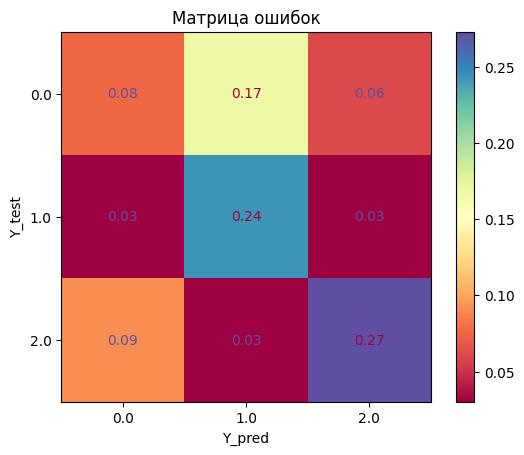

              precision    recall  f1-score   support

      Normal       0.38      0.25      0.30        20
       Viral       0.55      0.80      0.65        20
    Covid-19       0.75      0.69      0.72        26

    accuracy                           0.59        66
   macro avg       0.56      0.58      0.56        66
weighted avg       0.58      0.59      0.57        66



In [51]:
# Обучение и проверка модели на основе KNearestNeighbors
model_KNN = KNeighborsClassifier(n_neighbors=10**1) # инициализация модели на основе KNearestNeighbors
model_KNN.fit(X_train,y_train) # обучение модели
y_pred = model_KNN.predict(X_test) # тестирование модели
cm_model_KNN = confusion_matrix(y_test,y_pred, normalize='all') # матрица ошибок
#
#Визуализация матрицы ошибок
plt.figure(figsize=(6,6))
graph = ConfusionMatrixDisplay(confusion_matrix=cm_model_KNN, display_labels=model_KNN.classes_)
graph.plot(cmap='Spectral', values_format='.2f')
plt.xlabel('Y_pred')
plt.ylabel('Y_test')
plt.title('Матрица ошибок')
plt.show()
#
# Отчет по классификации
print(classification_report(y_test,y_pred, target_names=['Normal','Viral','Covid-19']))

/home/full-master/Документы/myenv/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


<Figure size 600x600 with 0 Axes>

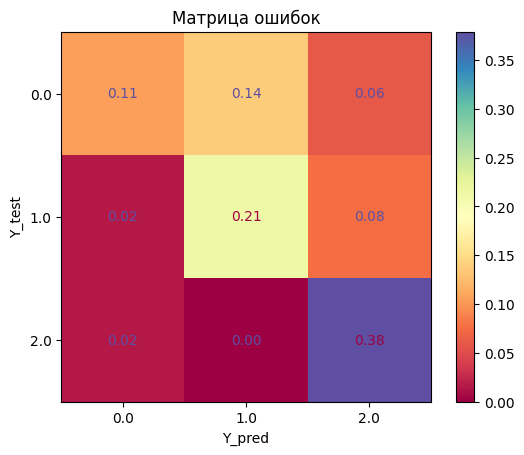

              precision    recall  f1-score   support

      Normal       0.78      0.35      0.48        20
       Viral       0.61      0.70      0.65        20
    Covid-19       0.74      0.96      0.83        26

    accuracy                           0.70        66
   macro avg       0.71      0.67      0.66        66
weighted avg       0.71      0.70      0.67        66



In [52]:
# Обучение и проверка модели на основе RandomForestTree
model_RFT = RandomForestClassifier(random_state=18) # инициализация модели на основе RandomForestTree
model_RFT.fit(X_train, y_train) # обучение модели
y_pred = model_RFT.predict(X_test) # тестирование модели
cm_model_RFT = confusion_matrix(y_test,y_pred, normalize='all') # матрица ошибок
#
#Визуализация матрицы ошибок
plt.figure(figsize=(6,6))
graph = ConfusionMatrixDisplay(confusion_matrix=cm_model_RFT, display_labels=model_RFT.classes_)
graph.plot(cmap='Spectral', values_format='.2f')
plt.xlabel('Y_pred')
plt.ylabel('Y_test')
plt.title('Матрица ошибок')
plt.show()
#
# Отчет по классификации
print(classification_report(y_test,y_pred, target_names=['Normal','Viral','Covid-19']))

/home/full-master/Документы/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<Figure size 600x600 with 0 Axes>

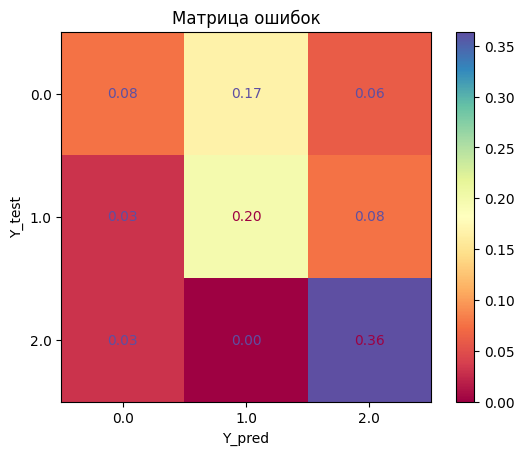

              precision    recall  f1-score   support

      Normal       0.56      0.25      0.34        20
       Viral       0.54      0.65      0.59        20
    Covid-19       0.73      0.92      0.81        26

    accuracy                           0.64        66
   macro avg       0.61      0.61      0.58        66
weighted avg       0.62      0.64      0.60        66



In [53]:
# Обучение и проверка модели на основе GradientBoosting
model_GB = GradientBoostingClassifier(random_state=18) # Инициализация модели на основе GradientBoosting
model_GB.fit(X_train, y_train) # обучение модели
y_pred = model_GB.predict(X_test) # тестирование модели
cm_model_GB = confusion_matrix(y_test,y_pred, normalize='all') # матрица ошибок
#
#Визуализация матрицы ошибок
plt.figure(figsize=(6,6))
graph = ConfusionMatrixDisplay(confusion_matrix=cm_model_GB, display_labels=model_GB.classes_)
graph.plot(cmap='Spectral', values_format='.2f')
plt.xlabel('Y_pred')
plt.ylabel('Y_test')
plt.title('Матрица ошибок')
plt.show()
#
# Отчет по классификации
print(classification_report(y_test,y_pred, target_names=['Normal','Viral','Covid-19']))